In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
from tqdm import tqdm

In [2]:
dir = 'Tensorflow\workspace\images\\train 10'
label_map = pd.read_csv('baybayin character 9.csv')

In [3]:
data = []

for index, row in label_map.iterrows():
    category = row['label']
    label = row['id']
    path = os.path.join(dir, category)

    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        a_img = cv2.imread(imgpath, 0)

        # Apply Gaussian blur to the image
        a_img = cv2.GaussianBlur(a_img, (5, 5), cv2.BORDER_DEFAULT)

        # Apply Otsu thresholding to the image
        _, a_img = cv2.threshold(a_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Apply edge detection to the image
        #a_img = cv2.Canny(a_img, 100, 200)

        # Rotate the image randomly between -15 to 15 degrees
        rows, cols = a_img.shape[:2]
        angle = np.random.randint(-15, 15)
        rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        a_img = cv2.warpAffine(a_img, rotation_matrix, (cols, rows))

        # Flip the image horizontally with 50% probability
        if random.random() < 0.5:
            a_img = cv2.flip(a_img, 1)

        a_img = cv2.resize(a_img, (50, 50))
        image = np.array(a_img).flatten()

        data.append([image, label])

print(len(data))

3500


In [4]:
random.shuffle(data)
features = []
labels = []

for feature,label in data:
    features.append(feature)
    labels.append(label)

In [5]:
#split data
#features = np.array(features)
#labels = np.array(labels)
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.20)

In [6]:
# Set up a checkpoint directory to save the model checkpoints.
checkpoint_dir = "model_checkpoints_3.1/"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [7]:
# Train the model and save checkpoints
model = SVC(C= 25, kernel='rbf', gamma = 1e-07)

progress = tqdm(range(0, 100, 10), desc="Training", unit="epoch")
for i in progress:
    # Fit the model for each epoch
    model.fit(xtrain, ytrain)
    # Save the checkpoint
    checkpoint_file = os.path.join(checkpoint_dir, f"model_{i+1}.sav")
    pickle.dump(model, open(checkpoint_file, "wb"))
    # Calculate and display the accuracy on the test set
    accuracy = model.score(xtest, ytest)
    progress.set_postfix({"accuracy": accuracy})

Training: 100%|█████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.11s/epoch, accuracy=1]


In [9]:
# Save the final trained model to a file.
final_model_file = "svm_baybayin_rbf_2.5.sav"
pickle.dump(model, open(final_model_file, 'wb'))

In [6]:
# Load the fine-tuned model
model_file = "svm_baybayin_rbf_2.6.sav"
with open(model_file, 'rb') as f:
    svm_model = pickle.load(f)

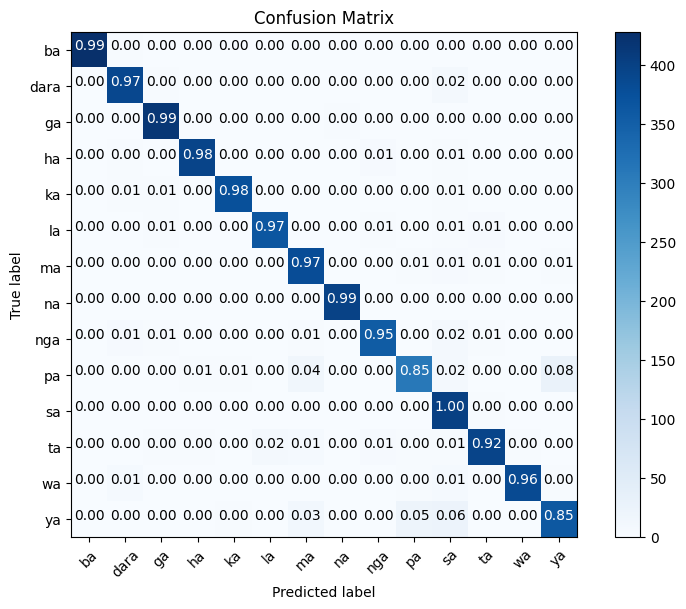

In [7]:
from sklearn.metrics import confusion_matrix
import itertools

# Generate the confusion matrix
y_pred = svm_model.predict(xtest)
class_names = ['ba', 'dara', 'ga', 'ha', 'ka', 'la', 'ma', 'na', 'nga', 'pa', 'sa', 'ta', 'wa', 'ya']
cm = confusion_matrix(ytest, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thresh = cm_normalized.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [8]:
#'a','ba', 'dara', 'ei', 'ga', 'ha', 'ka', 'la', 'ma', 'na', 'nga', 'ou', 'pa', 'sa', 'ta', 'wa', 'ya'

In [9]:
from sklearn.metrics import precision_score, recall_score
# Make predictions using the SVM model
y_pred = svm_model.predict(xtest)

# Calculate precision and recall
precision = precision_score(ytest, y_pred, average='macro')
recall = recall_score(ytest, y_pred, average='macro')

# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Precision: 0.96
Recall: 0.95


predicted: [2 3 3 ... 3 2 2]


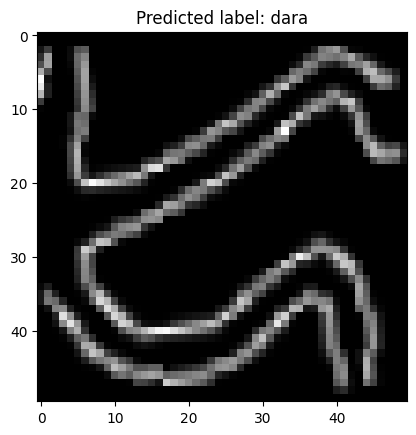

In [10]:
# Test the model.
prediction = model.predict(xtest)

# Print the predicted labels.
print('predicted:', prediction)

# Decode the predicted labels using the label_map DataFrame.
predicted_labels = [label_map[label_map['id']==label]['label'].values[0] for label in prediction]

# Show an example.
baybayin = xtest[2].reshape(50, 50)
plt.imshow(baybayin, cmap='gray')
plt.title('Predicted label: ' + predicted_labels[2])
plt.show()


In [16]:
#w/o ei
from sklearn.model_selection import GridSearchCV
parameters = {'C': [0.000001, 0.0001, 0.1, 10], 'gamma': [0.00000001, 0.0000001, 0.1]}
grid_search = GridSearchCV(SVC(kernel='poly'), parameters, verbose=1)
grid_search.fit(xtrain, ytrain)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1e-06, 'gamma': 0.1}
Best Accuracy: 0.7725


In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [0.0000001, 0.1, 10], 'gamma': [0.0000001, 0.0001, 0.1]}
grid_search = GridSearchCV(SVC(kernel='rbf'), parameters, verbose=1)
grid_search.fit(xtrain, ytrain)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 10, 'gamma': 1e-07}
Best Accuracy: 0.85375


In [7]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [25, 30, 20, 1], 'gamma': [0.01, 0.0001, 0.00001]}
grid_search = GridSearchCV(SVC(kernel='linear'), parameters)
grid_search.fit(xtrain, ytrain)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'C': 25, 'gamma': 0.01}
Best Accuracy: 0.93510101010101
